<a href="https://colab.research.google.com/github/AlexeyUdod/aml/blob/master/dll_9_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
%matplotlib inline

In [23]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
!wget https://www.manythings.org/anki/rus-eng.zip
!unzip rus-eng.zip

--2021-04-27 21:52:01--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.21.55.222, 2606:4700:3031::6815:37de, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14042100 (13M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  13.39M  3.03MB/s    in 8.8s    

2021-04-27 21:52:10 (1.51 MB/s) - ‘rus-eng.zip’ saved [14042100/14042100]

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [25]:
# !tail data/eng-fra.txt
!tail rus.txt

Tom said, "You can kiss your girlfriend goodbye if you don't kiss her goodbye," which meant, "If you don't kiss your girlfriend goodbye, then you'll never see her again."	«Можешь попрощаться со своей подружкой, если ты с ней не попрощаешься», — сказал Том, что означало «если ты не попрощаешься со своей подружкой, то больше ты её никогда не увидишь».	CC-BY 2.0 (France) Attribution: tatoeba.org #1065032 (CK) & #4435211 (sharptoothed)
The more countries a language is spoken in, the less important it is to sound like a native speaker, since speakers of that language are accustomed to hearing various dialects.	Чем в большем количестве стран используется тот или иной язык, тем менее важно иметь такое же произношение, как у его носителей, так как носители этого языка привыкли к звучанию различных акцентов.	CC-BY 2.0 (France) Attribution: tatoeba.org #954354 (CK) & #4465953 (Wezel)
A mistake young people often make is to start learning too many languages at the same time, as they underestimate

In [26]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [27]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-Я.!?]+", r" ", s)
    return s

In [28]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    # lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
    #     read().strip().split('\n')
    lines = open('rus.txt', encoding='utf-8').read().strip().split('\n')


    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:-1]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [29]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [30]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


# input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
input_lang, output_lang, pairs = prepareData('eng', 'rus', True)

print(random.choice(pairs))

Reading lines...
Read 421765 sentence pairs
Trimmed to 24895 sentence pairs
Counting words...
Counted words:
rus 9419
eng 4063
['он без ума от нее .', 'he s crazy about her .']


The Encoder
-----------





In [31]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------




In [80]:
class AttnDecoderRNN_MLP(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_MLP, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        output = self.attn_combine(torch.cat((embedded[0], attn_applied[0]), 1)).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [73]:
class AttnDecoderRNN_scalar(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_scalar, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax((embedded[0] @ encoder_outputs.T) / self.max_length**0.5, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        output = self.attn_combine(torch.cat((embedded[0], attn_applied[0]), 1)).unsqueeze(0)

#  embedded[0] [1, 256], hidden[0] [1, 256], encoder_outputs [10, 256], attn_weights [1, 10], attn_applied [1, 1, 256], output [1, 1, 256]

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [33]:
# mask = hidden + emb_word
# input = emb_word + emb_sent * mask
# emb_word_next, hidden_next = RNN(input, hidden)


# input =
# emb_word + emb_word * emb_sent  + emb_sent * hidden 
# emb_word * (1 + emb_sent) + emb_sent * hidden 
# emb_word * (1 + 1 / emb_sent) +  hidden 

In [34]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [35]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [36]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [37]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [38]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [39]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [40]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [85]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN_MLP(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
attn_decoder2 = AttnDecoderRNN_scalar(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
decoder_list = [attn_decoder1, attn_decoder2]
for decoder in decoder_list:
    print(f'\n\n{decoder.__class__.__name__}\n\ntraining')
    trainIters(encoder1, attn_decoder2, 50000, print_every=5000)
    print('\nevaluate\n')
    evaluateRandomly(encoder1, decoder)



AttnDecoderRNN_MLP

training
1m 5s (- 9m 52s) (5000 10%) 3.0708
2m 10s (- 8m 41s) (10000 20%) 2.5936
3m 15s (- 7m 36s) (15000 30%) 2.3280
4m 20s (- 6m 31s) (20000 40%) 2.1385
5m 26s (- 5m 26s) (25000 50%) 1.9900
6m 31s (- 4m 21s) (30000 60%) 1.8709
7m 36s (- 3m 15s) (35000 70%) 1.7295
8m 42s (- 2m 10s) (40000 80%) 1.6490
9m 47s (- 1m 5s) (45000 90%) 1.5501
10m 53s (- 0m 0s) (50000 100%) 1.4870

evaluate

> я неудачник .
= i m a loser .
< persistent persistent unprepared juice unprepared four excited excited compliments shaves

> ты расстраиваешь тома .
= you re upsetting tom .
< identical rumors handkerchiefs handkerchiefs jaybird lonely data data prejudiced prejudiced

> мы все очень гордимся томом .
= we re all very proud of tom .
< breeding clock curious data data prejudiced prejudiced face face face

> я совершенно честен .
= i m being totally honest .
< north north along achievements north unprepared spitting sank harvard perceptive

> я пытаюсь произвести впечатление на тома .


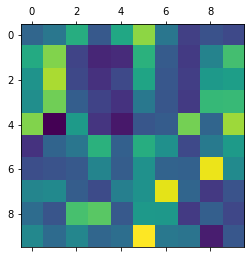

In [90]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "ты лишь на три года старше меня .")
plt.matshow(attentions.numpy())
plt.show()

input = я устал от ваших жалоб .
output = smoker hospital along shaves road infected absorbed approve passports shaves


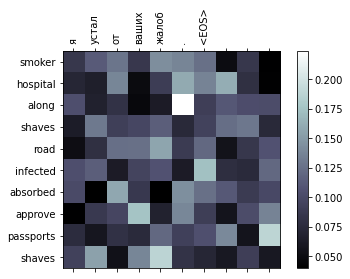

input = я добр с томом .
output = bleeding trouble bleeding nicely nicely anything biological biological die checks


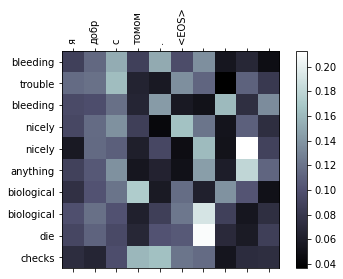

input = она программистка .
output = unpopular trespassing trespassing your your lonely data seventh disobedient rolling


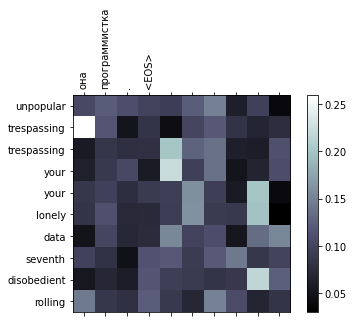

input = он не уверен в своем будущем .
output = unpopular outspoken north old honeymoon honeymoon extraordinary chronic king king


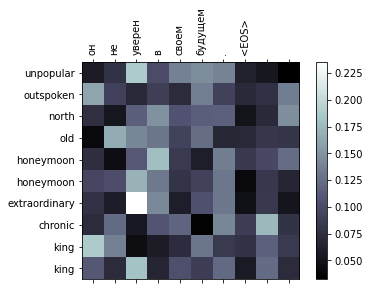

In [89]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("я устал от ваших жалоб .")

evaluateAndShowAttention("я добр с томом .")

evaluateAndShowAttention("она программистка .")

evaluateAndShowAttention("он не уверен в своем будущем .")